# TimbreXSpectrum Decoder
This is the notebook used to train the Vocal Pitch Modulator.

This notebook makes use of the timbre encoder and spectrum data to train our decoder.

## Global variables/Imports
Run these cells before running either of the following sections.

In [1]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *

In [2]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used to tune the data generation and ANN.

In [10]:
n_ffts = 2048
n_mels = 256
n_mfcc = 12
n_timb_hid = 10; n_timb = 6
TE_path = os.path.join('model_data', 'TimbreVAE-Ideal-12-10-6.pt')

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

The first cell involves 3d arrays, while the second cell involves flattened arrays.

In [4]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# Data-label pairs for pitch-shift training
data_label_pairs_flat, data_label_pairs_dict = create_data_label_pairs(n_pitches)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list. n_windows is 115 with 75% overlap.
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 1025, 29) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 256, 29) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 12, 29)  (n_wavs, n_mfcc, n_windows)
all_wav_data = load_wav_files(os.path.join("Data", "dataset"), flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, win_length=n_ffts, overlap=.5, plot=False) 
                              for waveform in all_wav_data ])

all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))

n_files, _, n_windows = all_mfcc.shape

In [6]:
print(all_wav_data.shape)
print(all_spectrograms.shape)
print(all_mels.shape)
print(all_mfcc.shape)

(576,)
(576, 1025, 29)
(576, 256, 29)
(576, 12, 29)


In [87]:
# Flattened data

# Create data accessor for flat arrays
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)


# Create flat mel spectra 
# flat_mels: (33408, 128)
flat_mels_prenorm = np.array([ all_mels[wav_file_idx][:, window_idx] 
                               for wav_file_idx in range(n_files) 
                               for window_idx in range(n_windows) ])
# Normalize each mel-spectra by log then to [-1,1]
flat_mels_logged = np.log(flat_mels_prenorm)
max_mels = np.max(np.abs(flat_mels_logged))
flat_mels = flat_mels_logged / max_mels
flat_mels = torch.Tensor(flat_mels)


# Create timbre features by calling TE encoding on mfccs
# flat_mfcc: (33408, 20)
flat_mfcc_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx]
                               for wav_file_idx in range(n_files)
                               for window_idx in range(n_windows) ])
# Normalize each mfcc (i.e. rows of the all_mfcc array) to [0,1]
flat_mfcc_signs = np.sign(flat_mfcc_prenorm)
flat_mfcc_logged = np.log(np.abs(flat_mfcc_prenorm))
max_mfcc = np.max(np.abs(flat_mfcc_logged))
flat_mfcc = flat_mfcc_logged / max_mfcc
flat_mfcc = torch.Tensor(flat_mfcc)

# Load the timbre encoder
TE = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_timb_hid, n_timb=n_timb)
TE.load_state_dict(torch.load(TE_path))
TE.eval()
# Call the timbre VAE's encode 
# flat_timbre: (33408, 4)
flat_timbre_prenorm = TE.get_z(flat_mfcc).detach().numpy()
max_timbre = np.max(np.abs(flat_timbre_prenorm))
flat_timbre = flat_timbre_prenorm / max_timbre

Text(0.5, 1.0, 'Restored MFCC: (16704, 12)')

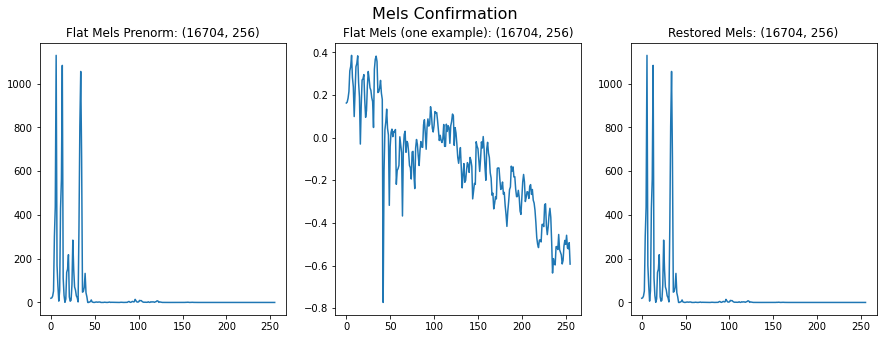

<Figure size 432x288 with 0 Axes>

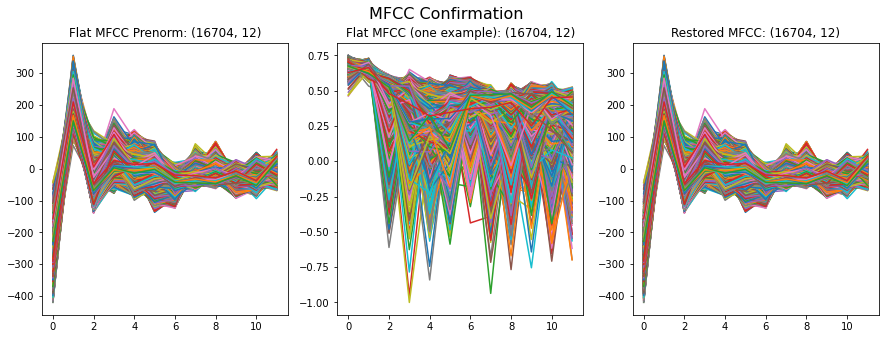

<Figure size 432x288 with 0 Axes>

In [90]:
# Visualize and verify Mels
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.figure()
fig.suptitle("Mels Confirmation", fontsize=16)
ax[0].plot(flat_mels_prenorm[0])
ax[0].set_title("Flat Mels Prenorm: {}".format(flat_mels_prenorm.shape))
ax[1].plot(flat_mels[0])
ax[1].set_title("Flat Mels (one example): {}".format(flat_mels.detach().numpy().shape))
ax[2].plot(np.e ** (flat_mels[0] * max_mels))
ax[2].set_title("Restored Mels: {}".format(flat_mels.detach().numpy().shape))

# Visualize and verify MFCC
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.figure()
fig.suptitle("MFCC Confirmation", fontsize=16)
ax[0].plot(flat_mfcc_prenorm.T)
ax[0].set_title("Flat MFCC Prenorm: {}".format(flat_mfcc_prenorm.shape))
ax[1].plot(flat_mfcc.T)
ax[1].set_title("Flat MFCC (one example): {}".format(flat_mfcc.detach().numpy().shape))
ax[2].plot((flat_mfcc_signs * np.e ** (flat_mfcc.detach().numpy() * max_mfcc)).T)
ax[2].set_title("Restored MFCC: {}".format(flat_mfcc.detach().numpy().shape))

In [73]:
x = np.array([ np.max(arr) for arr in flat_mfcc.detach().numpy() ])
np.argmax(x)

2088

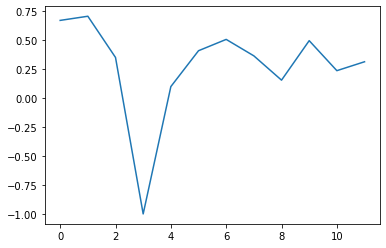

In [91]:
plt.figure()
plt.plot(flat_mfcc[2088])

[ 0.6703052   0.70615196  0.35050556 -1.          0.09897564  0.40857542
  0.50628686  0.36419752  0.15455504  0.4953864   0.23641866  0.313328  ]
[ 5.395521   5.684064   2.8213418 -8.04935    0.7966895  3.2887664
  4.07528    2.9315534  1.2440675  3.9875383  1.9030166  2.5220866]
[5.395521  5.684064  2.8213418 8.04935   0.7966895 3.2887664 4.07528
 2.9315534 1.2440675 3.9875383 1.9030166 2.5220866]
[-2.2041696e+02  2.9414233e+02 -1.6799376e+01 -3.1930956e-04
 -2.2181854e+00  2.6809767e+01 -5.8866966e+01  1.8756742e+01
 -3.4696980e+00 -5.3921982e+01  6.7060928e+00  1.2454556e+01]

[-2.2041695e+02  2.9414243e+02 -1.6799376e+01 -3.1930953e-04
 -2.2181854e+00  2.6809769e+01 -5.8866982e+01  1.8756742e+01
 -3.4696980e+00 -5.3921989e+01  6.7060933e+00  1.2454557e+01]
[2.2041695e+02 2.9414243e+02 1.6799376e+01 3.1930953e-04 2.2181854e+00
 2.6809769e+01 5.8866982e+01 1.8756742e+01 3.4696980e+00 5.3921989e+01
 6.7060933e+00 1.2454557e+01]
[ 5.395521   5.684064   2.8213418 -8.04935    0.7966895 

array([-2.2041696e+02,  2.9414233e+02, -1.6799376e+01, -3.1317573e+03,
       -2.2181854e+00,  2.6809767e+01, -5.8866966e+01,  1.8756742e+01,
       -3.4696980e+00, -5.3921982e+01,  6.7060928e+00,  1.2454556e+01],
      dtype=float32)

## Pre-Training - "Autoencoder" Stage

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from timbre features (which requires the use of the TimbreVAE) and mel spectrums. `labels` are abs(fft) spectrograms. At this stage, pre-training, we simply want to make the NN learn to output fourier spectra.

Note that mel_spectra/mfcc of abs(fft) are equivalent to those of fft itself.

In [36]:
# Create labels

# data:   (33408, 132) (n_wavs * n_windows, n_timb + n_mels)
# labels: (33408, 513) (n_wavs * n_windows, n_fft / 2 + 1)
data = np.concatenate((flat_timbre, flat_mels), axis=1)
labels_prenorm = np.array([ all_abs_spectrograms[wav_file_idx][:, window_idx]
                            for wav_file_idx in range(n_files)
                            for window_idx in range(n_windows) ])
labels, label_scales = normalize_rows(labels_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
print(data.shape, labels.shape)

(16704, 262) (16704, 1025)


In [ ]:
np.max(labels_prenorm)

In [ ]:
# Doesn't work after normalization.
# # For testing purposes - VERY SLOW
# # Verify that the timbre and mels have been arranged in order of
# # wav_idx, win_idx, [timbre then mel_idx]
# for wav_idx in range(n_files):
#     for win_idx in range(n_windows):
#         for t in range(n_timb):
#             assert data[flat_data_idx(wav_idx, win_idx)][t] == \
#                    flat_timbre[flat_data_idx(wav_idx, win_idx)][t]
#         for m in range(n_mels):
#             assert data[flat_data_idx(wav_idx, win_idx)][m + n_timb] == \
#                    all_mels[wav_idx][m][win_idx]

# # Verify that the labels are arranged in order of wav_idx, win_idx, fft_bin_idx
# for wav_idx in range(n_files):
#     for win_idx in range(n_windows):
#         for f in range(513):
#             assert labels[flat_data_idx(wav_idx, win_idx)][f] == \
#                    all_abs_spectrograms[wav_idx][f][win_idx]

Split Data into `train` and `test`, and convert to Torch tensors of the correct types. Run **only one of these cells.**

First method (**not-recommended**, simple): Random sampling to train and test

In [ ]:
# X_train, Y_train: (25056, 20) (25056) 
# X_val, Y_val:     (8352, 20) (8352)
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, random_state=0)
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
Y_train = Y_train.float(); Y_val = Y_val.float()

Second method **(recommended)**: 1 person from each wav will be the test data

In [ ]:
# X_train, Y_train: (22272, 132) (22272, 513) 
# X_val, Y_val:     (11136, 132) (11136, 513)
X_train = []; X_val = []; Y_train = []; Y_val = []
for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        # Choose the person for this pitch/vowel to be used as test data
        test_pid = int(np.random.rand() * 3)
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
            if (pid_idx != test_pid):
                for win_idx in range(n_windows):
                    X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_train.append(labels[flat_data_idx(wav_idx, win_idx)])
            else:
                for win_idx in range(n_windows):
                    X_val.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_val.append(labels[flat_data_idx(wav_idx, win_idx)])  
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
Y_train = Y_train.float(); Y_val = Y_val.float()

### Autoencoder stage - Timb + Mel -> FFT (decoder style, no pitch shift)

This takes a timbre vector and mel spectrum, and tries to recreate the original FFT.


In [ ]:
n_input = 132; n_hid2 = 386; n_hid = 260; n_output = 513; 
lr = 0.2; n_epochs = 500; batch_size=22272//8;

# Training model 
model = TimbreMelDecoder(n_input=n_input, n_hid=n_hid, n_hid2=n_hid2, n_output=n_output)
# Define loss 
loss_fn = nn.MSELoss()
# Just trying out some different loss functions that consider log
loss_fn = nn.KLDivLoss()
# loss_fn = nn.NLLLoss()

In [ ]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

In [ ]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, batch_size=batch_size, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(train_loss, toc - tic))

Saving the model

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreDecoder_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_hid, n_hid2, n_ffts, train_loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Loading the saved model, and using the model for prediction example

In [ ]:
model = TimbreMelDecoder(n_input=n_input, n_hid=n_hid, n_hid2=n_hid2, n_ffts=n_ffts)
model.load_state_dict(torch.load(model_path))
model.eval()
# model.to(device)

data_tensor, label_tensor = map(torch.tensor, (data, labels))
data_tensor = data_tensor.float(); label_tensor = label_tensor.long(); 
# data_tensor = data_tensor.to(device); label_tensor = label_tensor.to(device)
predictions = model(data_tensor).detach().numpy()


x_axis = librosa.core.fft_frequencies(sample_rate, 1024)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, predictions[30000], label='Prediction', linewidth=1)
plt.plot(x_axis, label_tensor[30000], label='Label', linewidth=1)
plt.xlim(0, 5000)
plt.xlabel('Frequency')
plt.ylabel('abs(fft)')
plt.legend(loc='best')
plt.title("Output-Label for data point 30000")

# These are rough work
No guarantee that this cell even works. Tests to see how bad reconstructed sound without phase information is

In [ ]:
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 128, 58) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 20, 58)  (n_wavs, n_mfcc, n_windows)
# all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
#                               flat_data_ref_list)
# all_spectrograms = np.array([ stft(waveform, plot=False) 
#                               for waveform in all_wav_data ])
# all_mels, all_mfcc = map(np.array, map(list, zip(*
#                          [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
#                            for ffts in all_spectrograms ])))

# Vowel, pitch, person
CAT_D3_IDX = flat_ref_idx(4, 5, 0)

# The original
wavform_original = np.array(all_wav_data[CAT_D3_IDX] * np.iinfo(np.int16).max, dtype=np.int16)
sio.wavfile.write('Original {} {}.wav'.format(label_to_vowel[4], noteidx_to_pitch[5]), 44100, wavform_original)
print(wavform_original.shape)

# The reconstructed signal - it's normalized so it's louder, but no obvious differences

istft_waveform = istft(all_spectrograms[CAT_D3_IDX], overlap=.75)
print(np.array(istft_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('ISTFT {} {}.wav'.format(label_to_vowel[4], noteidx_to_pitch[5]), 44100, istft_waveform)
plt.plot(istft_waveform)
print(istft_waveform.shape)

# Realed signal with ISTFT - sounds very bad
istft_abs_waveform = istft(np.abs(all_spectrograms[CAT_D3_IDX]), overlap=.75)
print(np.array(abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('ISTFT(ABS) {} {}.wav'.format(label_to_vowel[4], noteidx_to_pitch[5]), 44100, istft_abs_waveform)
plt.figure()
plt.plot(istft_abs_waveform)
print(istft_abs_waveform.shape)

# Realed signal with griffinlim - noisy but acceptable
gl_abs_waveform = librosa.griffinlim(np.abs(all_spectrograms[CAT_D3_IDX]), win_length=1024)
print(np.array(abs_waveform * np.iinfo(np.int16).max, dtype=np.int16))
sio.wavfile.write('GL(ABS) {} {}.wav'.format(label_to_vowel[4], noteidx_to_pitch[5]), 44100, gl_abs_waveform)
plt.figure()
plt.plot(gl_abs_waveform)
print(gl_abs_waveform.shape)